In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'
os.environ['XLA_FLAGS']='--xla_force_host_platform_device_count=8'
os.environ['JAX_PLATFORM_NAME']='cpu'
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import numpy as np
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt

# Build Porqueres et al. (2023) simulation setting
# https://arxiv.org/abs/2304.04785
from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.experimental import mesh_utils
from scipy.stats import norm
from jaxpm.distributed import normal_field

In [2]:
print(jax.devices())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [3]:
pdims = (8, 1)
devices = mesh_utils.create_device_mesh(pdims)
mesh = Mesh(devices.T, axis_names=('x', 'y'))
my_sharding = NamedSharding(mesh, P('x', 'y'))

In [4]:
z = np.linspace(0, 2.5, 1000)

nz_shear = [jc.redshift.kde_nz(z,
                               norm.pdf(z, loc=z_center, scale=0.12) ,
                               bw=0.01, zmax=2.5, gals_per_arcmin2=g )
                for z_center, g in zip([0.5, 1., 1.5, 2.], [7,8.5, 7.5, 7])]
nbins = len(nz_shear)

# Define the fiducial cosmology
Omega_b = 0.049
Omega_c = 0.315 - Omega_b
sigma_8 = 0.8
h = 0.677
n_s = 0.9624
w0 = -1
cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma_8, Omega_b=Omega_b,
                      h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)

# Specify the size and resolution of the patch to simulate
field_size = 16.   # transverse size in degrees
field_npix = 64    # number of pixels per side
sigma_e = 0.3
print("Pixel size in arcmin: ", field_size * 60 / field_npix)


Pixel size in arcmin:  15.0


In [5]:
from jax_lensing.dist_model import make_full_field_model

box_size  = [1000., 1000., 4500.]     # In Mpc/h
box_shape = [64,  64,  128]           # Number of voxels/particles per side
halo_size = 16
sharding = my_sharding
# Generate the forward model given these survey settings
lensing_model = jax.jit(make_full_field_model( 
                                            field_size=field_size,
                                            field_npix=field_npix,
                                            box_size=box_size,
                                            box_shape=box_shape,
                                            halo_size=halo_size,
                                            sharding=sharding))

In [6]:
def model(z,om,s8):
  Omega_c = om
  Omega_b = 0.049
  sigma8 = s8
  h = 0.677
  n_s = 0.9624
  w0 = -1
  cosmo = jc.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, sigma8=sigma8,
                       h=h, n_s=n_s, w0=w0, wa=0., Omega_k=0.)
                       
  convergence_maps, lc = lensing_model(cosmo, nz_shear, z)
  return convergence_maps, lc




In [7]:
z = normal_field(mesh_shape=box_shape,seed=jax.random.PRNGKey(0),sharding=sharding)
om = cosmo.Omega_c
s8 = cosmo.sigma8

In [8]:
z.addressable_data(0).shape

(64, 8, 128)

In [9]:
kappa_obs , lc= model(z,om,s8)

local_shape is (64, 8, 128, 3)


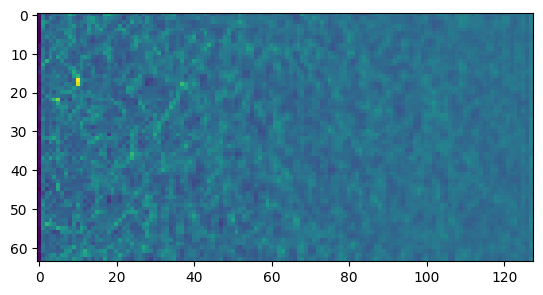

In [10]:
plt.imshow(lc[:10].sum(axis=0))

In [11]:
jnp.allclose(kappa_obs[0],kappa_obs[1])

Array(False, dtype=bool)

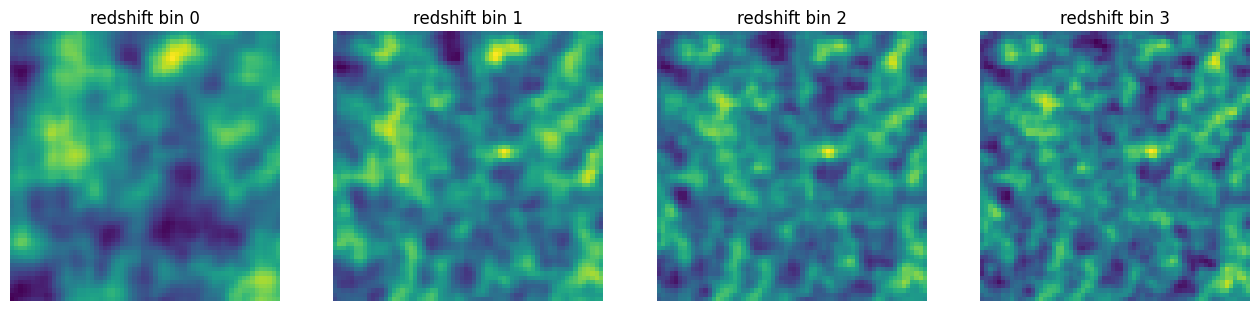

In [12]:
# plotting the trace
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
plt.figure(figsize=[16,4])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title('redshift bin %d'%i)
    plt.imshow(gaussian_filter(kappa_obs[i],0.))
    plt.axis('off')

In [13]:
from collections import namedtuple

ParamObj = namedtuple("ParamObj", ["z", "om", "s8"])

@jax.jit
def log_posterior(params):
    z, om, s8 = params

    convergence_maps , _ = model(z,om,s8)
    log_pz = -jnp.sum(z**2/2)
    log_likelihood = [(c - kappa_o)**2/(2 * sigma_e/jnp.sqrt(nz_shear[i].gals_per_arcmin2*(field_size*60/field_npix)**2)) \
        for i, (c, kappa_o) in enumerate(zip(convergence_maps, kappa_obs))]
    log_likelihood = -jnp.sum(sum(log_likelihood))
    return log_pz + log_likelihood

In [14]:
new_z = normal_field(mesh_shape=box_shape,seed=jax.random.PRNGKey(1),sharding=sharding)
om = cosmo.Omega_c + jax.random.normal(jax.random.PRNGKey(2), shape=(), dtype=jnp.float32)
s8 = cosmo.sigma8 + jax.random.normal(jax.random.PRNGKey(3), shape=(), dtype=jnp.float32)

om = cosmo.Omega_c
s8 = cosmo.sigma8
new_z = z

params = ParamObj(new_z, om, s8)


In [15]:
grad = jax.grad(log_posterior)(params)

local_shape is (64, 8, 128, 3)


In [16]:
grad.om, grad.s8

(Array(278.35587, dtype=float32), Array(-108.71421, dtype=float32))

In [17]:
z_new =  params.z - 0.1 * grad.z

In [18]:
z_new

Array([[[-0.8306334 , -1.1617785 ,  1.3282416 , ...,  0.57988966,
          0.09954183, -0.6448067 ],
        [ 0.916035  ,  0.9242543 , -0.7541896 , ..., -0.59412605,
         -0.7646709 ,  1.4012649 ],
        [ 0.58393157,  0.31370398,  0.71325004, ..., -0.04060131,
         -0.19877441,  0.6987006 ],
        ...,
        [ 0.36232424, -1.5943297 , -0.14095889, ..., -0.69959664,
          0.95474374, -1.498729  ],
        [ 0.5320105 ,  1.0031132 , -0.9827608 , ...,  0.8330044 ,
          0.19379632, -1.2687185 ],
        [-1.2087119 , -0.8282962 , -0.7766823 , ...,  1.7316862 ,
         -1.1153202 ,  2.1752217 ]],

       [[-0.11950981,  1.2394171 ,  1.1757151 , ..., -0.06972276,
          0.00471795, -0.485542  ],
        [ 0.7642975 ,  2.0765164 ,  1.1807798 , ..., -0.03576075,
          0.49728703,  2.3211553 ],
        [ 0.13779882,  0.44419095, -1.0526371 , ...,  1.8760877 ,
          1.2708166 , -1.1133705 ],
        ...,
        [-0.16278489,  0.98324686,  1.3876425 , ..., -

at iteration 0 grads om = nan, grads s8 = nan
at iteration 0, om = nan, s8 = nan grads om = nan, grads s8 = nan
at iteration 1 grads om = nan, grads s8 = nan
at iteration 1, om = nan, s8 = nan grads om = nan, grads s8 = nan


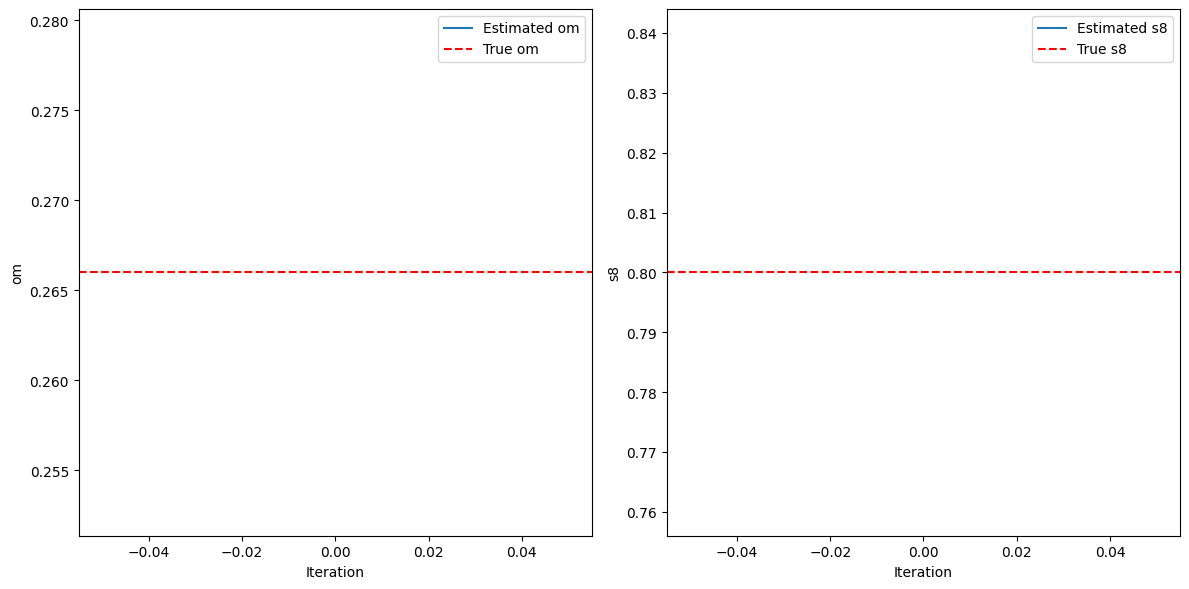

In [20]:
# Set the ground truth for reference
true_om = cosmo.Omega_c
true_s8 = cosmo.sigma8

# Initialize variables for gradient descent
learning_rate = 0.01  # Tune this for appropriate convergence
num_iterations = 2  # Number of gradient descent steps

# Keep track of parameter evolution
om_values = []
s8_values = []

for i in range(num_iterations):
    # Compute the gradients of the log posterior with respect to the parameters
    grad = jax.grad(log_posterior)(params)
    print(f"at iteration {i} grads om = {grad.om}, grads s8 = {grad.s8}")

    # Update the parameters using gradient descent
    z_new = params.z - learning_rate * grad.z
    om_new = params.om - learning_rate * grad.om
    s8_new = params.s8 - learning_rate * grad.s8
    print(f"at iteration {i}, om = {om_new}, s8 = {s8_new} grads om = {grad.om}, grads s8 = {grad.s8}")

    # Save the current values of om and s8
    om_values.append(om_new)
    s8_values.append(s8_new)

    # Update the parameters for the next iteration
    params = ParamObj(z_new, om_new, s8_new)

# Plotting the evolution of om and s8
plt.figure(figsize=[12, 6])

# Plot for om
plt.subplot(1, 2, 1)
plt.plot(om_values, label="Estimated om")
plt.axhline(y=true_om, color='r', linestyle='--', label="True om")
plt.xlabel("Iteration")
plt.ylabel("om")
plt.legend()

# Plot for s8
plt.subplot(1, 2, 2)
plt.plot(s8_values, label="Estimated s8")
plt.axhline(y=true_s8, color='r', linestyle='--', label="True s8")
plt.xlabel("Iteration")
plt.ylabel("s8")
plt.legend()

plt.tight_layout()
plt.show()